# Réseaux de neurones : Echo State Network

## Une brève introduction

Un <i>echo state network</i> est un réseau de neurones récurrents dont le réservoir est composé de neurones générés aléatoirement, et dont seuls les poids des sorties (donc entre le réservoir et la sortie) peuvent être modifiés. Nous allons ici développer un modèle d'ESN, issu d'un article de Mantas Lukoševičius.

In [1]:
%matplotlib inline

## Importation des modules

Commençons par importer les modules dont nous avons besoin. Outre la commande <i>%matplotlib inline</i> qui permet d'afficher les courbes directement dans le notebook, nous allons avoir besoin de <b>numpy</b> (module numérique destiné à la manipulation de vecteurs et de matrices), de <b>matplotlib</b> (pour tracer les courbes, donc), de <b>scipy</b> (la méthode linalg nous permettra d'importer des fonctions d'algèbre linéaire), ainsi que de widgets issus de <b>IPython</b>, qui nous permettront de rendre les courbes interactives à l'aide de curseurs permettant de modifier les variables en temps réel.

In [2]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševičius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
#from numpy import *
import numpy as np
#from matplotlib.pyplot import *
import matplotlib.pyplot as plt
#import scipy.linalg
from scipy import linalg
#from numpy import linalg
from ipywidgets import *
from IPython.display import *

## Remise à zéro de l'aléatoire

Ensuite, on va initier une première valeur pseudo-aléatoire en fonction du moment auquel est lancé le programme. Cela permet de s'assurer que deux exécutions du programme ne donneront pas le même résultat.

In [3]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Création d'une classe "Réseau"

On crée une classe <i>Réseau</i>. Un objet appartenant à cette classe contiendra, par défaut, quatre attributs :
<ul><li><b>initLen</b> : nombre d'itérations pour l'initalisation ;</li>
<li><b>trainLen</b> : nombre d'itérations pour l'entraînement ;</li>
<li><b>testLen</b> : nombre d'itérations pour le test ;</li>
<li><b>data</b> : fichier de données.</li></ul>

In [4]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.trainLen = trainLen
        self.testLen = testLen
        self.initLen = initLen
        self.data = np.loadtxt("MackeyGlass_t17.txt")

nw = Network()

## Affichage dynamique d'un échantillon de données

Nous allons maintenant afficher une partie des données du fichier <i>data</i>, en traçant les 5000 premières itérations. Vous pouvez modifier le nombre d'itérations à afficher en déplaçant le curseur.

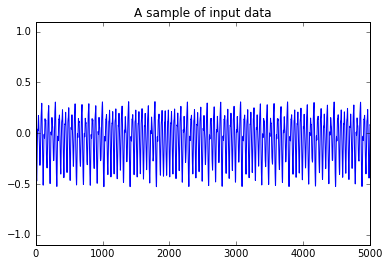

In [5]:
# plot some of it
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:f])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    #plt.show()
    
interact(plot_figure, f=(1000,10000,1000));

## Variables

Créons désormais notre réservoir. De base, celui-ci contient 300 neurones (<b>resSize</b>), l'entrée et la sortie sont de taille 1 (<b>inSize et outSize</b>). Cela nous donne un réseau sous cette forme : <img src="Reservoir3.png"></img>
Les neurones en entrée sont connectés aux neurones du réservoir. On représente donc les poids de chacune des connexions par une matrice <b style="color:#99cc00">W<sub>in</sub></b> (de taille inSize × resSize). De même, les connexions des neurones de la sortie sont représentées par la matrice <b style="color:#ff0000">W<sub>out</sub></b> (de taille resSize × outSize). Enfin, dans le réservoir, chaque neurone est lié à tous les autres neurones du réservoir (matrice <b style="color:#ffcc00">W</b>, de taille resSize × resSize).

Les valeurs des neurones du réservoir sont enregistrées au cours du temps dans une matrice <b style="color:#ffcc00">x</b> (de taille resSize × (initLen+trainLen)). Nous enregistrerons les valeurs des différents neurones au cours du temps dans la matrice <b style="color:#00baff">X</b>, contenant les valeurs du biais (<b style="color:#99cc00">1</b>), de l'entrée (<b style="color:#99cc00">u</b>), et des neurones du réservoir (<b style="color:#ffcc00">x</b>) au cours du temps (t). La matrice est ainsi de taille (1+inSize+resSize)×(initLen+trainLen)).

In [6]:
# generate the ESN reservoir
nw.inSize = nw.outSize = 1 #input/output dimension
nw.resSize = 300 #reservoir size (for prediction)
#resSize = 1000 #reservoir size (for generation)
nw.a = 0.3 # leaking rate 
nw.spectral_radius = 1.25
nw.input_scaling = 1.
nw.reg =  1e-8 #None # regularization coefficient, if None, pseudo-inverse
#is use instead of ridge regression

nw.mode = 'prediction'
#mode = 'generative'

#change the seed, reservoir performances should be averaged accross
#at least 20 random instances (with the same set of parameters)
seed = None #42

set_seed(seed) #random.seed(seed) 

664707927
Seed used for random values: 664707927


664707927

## Fonctions de traçages des courbes

On définit un certain nombre de fonctions permettant de tracer des courbes un peu plus tard.

In [7]:
# plot some signals
def plot_figure1(nw) :
    nw = calcul_reseau(nw)
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+nw.testLen+1], 'g' )
    plt.plot( nw.Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])

def plot_figure2(nw) :
    nw = calcul_reseau(nw)
    plt.figure(2).clear()
    #plot( X[0:20,0:200].T )
    plt.plot( nw.X[0:2,0:2000].T ) #xav
    plt.legend(["biais", "input"])
    plt.ylim([-1.1,1.1])
    plt.title('Input $\mathbf{u}(n)$ and bias for 2000 time steps')

def plot_figure3(nw,nb) :
    nw = calcul_reseau(nw)
    plt.figure(3).clear()
    plt.plot( nw.X[2:2+nb,0:200].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for 200 time steps')

def plot_figure4(nw,num) :
    nw = calcul_reseau(nw)
    plt.figure(4).clear()
    plt.plot( nw.X[2+num,:].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for all time steps')

def plot_figure5(nw,l) :
    nw = calcul_reseau(nw)
    plt.figure(5).clear()
    print(nw.X.shape)
    plt.plot( nw.X[2:,0:l].T )
    plt.ylim([-1.1,1.1])
    plt.title('All reservoir activations $\mathbf{x}(n)$ for '+str(l)+' time steps')

def plot_figure6(nw) :
    nw = calcul_reseau(nw)
    plt.figure(6).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

## Calcul du réseau en fonction des paramètres

On commence par générer aléatoirement les poids en entrée <b style="color:#99cc00">W<sub>in</sub></b>, ainsi que les poids <b style="color:#ffcc00">W</b> entre les neurones du réservoir.
Ensuite, on adapte l'échelle des poids <b style="color:#ffcc00">W</b> du réservoir, à l'aide du rayon spectral.

In [8]:
def initialisation(nw) :

    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    # Option 1 - direct scaling (quick&dirty, reservoir-specific):
    #W *= 0.135 
    # Option 2 - normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...',)
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    #np_rhoW = max(abs(np.linalg.eig(W)[0]))
    #print("Difference between scipy and numpy .eig() method: scipy="+str(rhoW)+" numpy="+str(np_rhoW)
    print('done.')
    nw.W *= nw.spectral_radius / rhoW
    
    #Matrice 
    # allocated memory for the design (collected states) matrix
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    # set the corresponding target matrix directly
    nw.Yt = nw.data[None,nw.initLen+1:nw.trainLen+1]

    # run the reservoir with the data and collect X
    nw.x = np.zeros((nw.resSize,1))

    print("a :", nw.a, "- spectral radius :", nw.spectral_radius, "- input scaling :", nw.input_scaling)   
    
    return(nw)

On passe ensuite à une phase d'apprentissage, qui va durer un nombre d'itérations défini (<b>trainLen</b>). En entrée, on utilise les données issues du fichier <i>data</i>. A chaque itération, on modifie la valeur de la donnée de chaque neurone du réservoir en fonction des poids <b style="color:#99cc00">W<sub>in</sub></b>. On se sert de la formule suivante :</br></br>
$$x_{n} = (1-\alpha)x_{n-1} \times \alpha \tanh(W_{in}.u_{n-1}) + W.x_{n-1}$$
Dans cette formule, le alpha agit comme un facteur de "mémoire" du réseau.
Une fois la période d'initialisation terminée (<b>initLen</b>), on commence à modifier la matrice <b style="color:#00baff">X</b>, qui va collecter les états des neurones durant la simulation : le premier neurone correspond au biais (<b style="color:#99cc00">1</b>), le second à l'entrée (<b style="color:#99cc00">u</b>), et tous les suivants à la matrice <b style="color:#ffcc00">x</b> :
$$X_{n} = [1;u_{n};x_{n}]$$

In [9]:
def train_input(nw) :
    #APPRENTISSAGE
    for t in range(nw.trainLen):
        #Données en entrée, issues de data
        nw.u = nw.data[t]
        
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #Au bout d'un certain temps, on modifie X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

On va maintenant passer à l'entraînement des poids en sortie <b style="color:#ff0000">W<sub>out</sub></b>.
$$W_{out} = (Y_{t}.X^{T}).(X.X^{T} + reg.I)^{-1}$$


In [10]:
def train_output(nw) :
    # train the output
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # use ridge regression (linear regression with regularization)
        nw.Wout = np.dot(np.dot(nw.Yt,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
        ### Just if you want to try the difference between scipy.linalg and numpy.linalg 
        ### which does not give the same results. For more info, see :
        ### https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference
        # np_Wout = np.dot(np.dot(Yt,X_T), np.linalg.inv(np.dot(X,X_T) + \
        # reg*np.eye(1+inSize+resSize) ) )
        # print("Difference between scipy and numpy .inv() method:\n\tscipy_mean_Wout="+\
        # str(np.mean(Wout))+"\n\tnumpy_mean_Wout="+str(np.mean(np_Wout))
    else:
        # use pseudo inverse
        nw.Wout = np.dot(nw.Yt, linalg.pinv(nw.X) )
        
    return(nw)

L'entrainement terminé, on peut maintenant passer au test du réseau.

In [11]:
def test(nw) :
    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")

    # compute MSE for the first errorLen time steps
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [12]:
def calcul_reseau(nw) :
    nw = initialisation(nw)
    nw = train_input(nw)
    nw = train_output(nw)
    nw = test(nw)    
    return(nw)

## Graphique 1 : Comparaison entre sorties attendues et sorties estimées

Computing spectral radius...
done.
a : 0.5 - spectral radius : 1.25 - input scaling : 1.0
MSE = 7.30578790739e-06


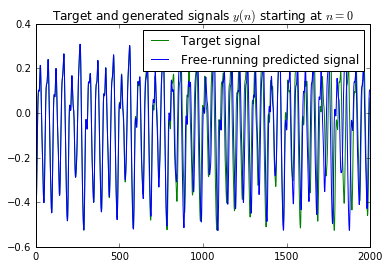

In [20]:
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=2000, step=1, description='trainLen')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph1(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    plot_figure1(nw)
    
valid.on_click(trace_graph1)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(valid)

## Graphique 2 : Affichage des données en entrée

On affiche, pour les 2000 premières itérations, les valeurs en entrée et le biais (toujours égal à 1).

Computing spectral radius...
done.
a : 0.3 - spectral radius : 1.25 - input scaling : 1.0
MSE = 2.41589026539e-08


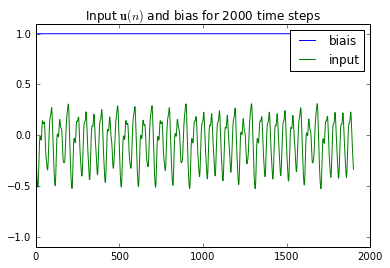

In [14]:
plot_figure2(nw)

## Graphique 3 : Affichage des activations des neurones (total)

Computing spectral radius...
done.
a : 0.5 - spectral radius : 1.25 - input scaling : 1.0
MSE = 8.10308837496e-09


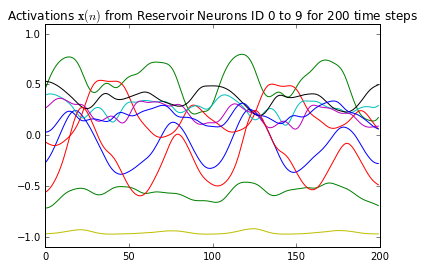

In [19]:
var4 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var5 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='nombre de neurones')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph3(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var4.value)
    nb=int(var5.value)
    plot_figure3(nw,nb)
    
valid.on_click(trace_graph3)
    
display(select_mode)
display(var4)
display(var5)
display(valid)

## Graphique 4 : Affichage des activations d'un neurone unique du réservoir

In [24]:
var10 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var11 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='neuron ID')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])

def trace_graph4(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var10.value)
    num=int(var11.value)
    plot_figure4(nw,num)
    
valid.on_click(trace_graph4)

display(select_mode)    
display(var10)
display(var11)
display(valid)

## Graphique 5 : Affichage de toutes les activations du réservoir

Computing spectral radius...
done.
a : 0.5 - spectral radius : 1.25 - input scaling : 1.0
MSE = 1.11126176904e-08
(496, 900)


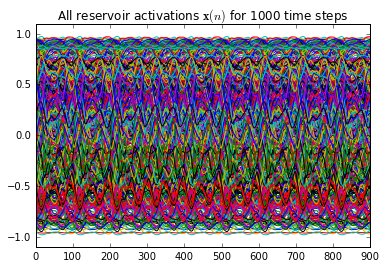

In [23]:
var13 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var14 = FloatSlider(value=300, min=0, max=2000, step=1, description='resSize')
var15 = FloatSlider(value=200, min=0, max=nw.testLen-nw.initLen, step=10, description='time steps')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='mode',
    options=['prediction', 'generative'])

def trace_graph5(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var13.value)
    nw.resSize=int(var14.value)
    l=int(var15.value)
    plot_figure5(nw,l)
    
valid.on_click(trace_graph5)
    
display(select_mode)
display(var13)
display(var14)
display(var15)
display(valid)

## Graphique 6 : Poids en sortie à la fin de la simulation

In [22]:
var16 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var17 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var18 = FloatSlider(value=1000, min=0, max=2000, step=1, description='trainLen')
valid = Button(description='Valider')
select_mode = ToggleButtons(description='mode',
    options=['prediction', 'generative'])

def trace_graph6(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.a=float(var16.value)
    nw.resSize=int(var17.value)
    nw.trainLen=int(var18.value)
    plot_figure6(nw)
    
valid.on_click(trace_graph6)

display(select_mode)
display(var16)
display(var17)
display(var18)
display(valid)